# 任务四:强化学习完成CartPole任务

### CartPole-v1
CartPole是gym提供的经典控制环境摆车，它要求给小车向左或向右的力，移动小车，让上面的杆子能竖起来。该环境有4个连续的环境状态和2个离散的动作。具体内容如下表所示：

环境状态：

| Num | Observation           | Min                 | Max               |
|-----|-----------------------|---------------------|-------------------|
| 0   | Cart Position         | -4.8                | 4.8               |
| 1   | Cart Velocity         | -Inf                | Inf               |
| 2   | Pole Angle            | ~ -0.418 rad (-24°) | ~ 0.418 rad (24°) |
| 3   | Pole Angular Velocity | -Inf                | Inf               |

动作：

| Num | Action                 |
|-----|------------------------|
| 0   | Push cart to the left  |
| 1   | Push cart to the right |

## 1.导入依赖包
* paddle框架
* gym环境库
* matplotlib画图工具
* tqdm进度条显示
* numpy科学计算库
* random随机操作库

In [1]:
import paddle
import paddle.nn.functional as F
import paddle.nn as nn
import gym
import matplotlib.pyplot as plt
from matplotlib import animation
from tqdm import tqdm
import numpy as np
import random

/opt/conda/envs/python35-paddle120-env/lib/python3.7/site-packages/matplotlib/__init__.py:107: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated, and in 3.8 it will stop working
  from collections import MutableMapping
/opt/conda/envs/python35-paddle120-env/lib/python3.7/site-packages/matplotlib/rcsetup.py:20: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated, and in 3.8 it will stop working
  from collections import Iterable, Mapping
/opt/conda/envs/python35-paddle120-env/lib/python3.7/site-packages/matplotlib/colors.py:53: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated, and in 3.8 it will stop working
  from collections import Sized


## 2.定义策略网络
策略网络：**两个全连接层**，最后的输出经过softmax函数处理（因为是动作是离散的）

PolicyNet表示智能体在状态s下，采取动作α概率。不同的策略函数，影响到智能体对action的选择，action又会影响到状态的迁移和得到的reward以及最终的回报。


In [2]:
class PolicyNet(paddle.nn.Layer):
    def __init__(self, state_dim, hidden_dim, action_dim):
        super(PolicyNet, self).__init__()
        self.fc1 = paddle.nn.Linear(state_dim, hidden_dim)
        self.fc2 = paddle.nn.Linear(hidden_dim, action_dim)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        return F.softmax(self.fc2(x))


## 3. 实现强化学习的多个版本算法
在强化学习中，智能体（agent）通过执行一系列动作(action)来影响环境，从而获得反馈信号，即奖励（reward）。

强化学习中，策略优化算法（如 Actor-Critic、PPO）的核心是**如何合理估计优势函数$A_t$，使得在每一次智能体与环境的交互中，通过优势函数衡量某个动作比平均策略好多少，从而更新策略（actor 网络）的参数，引导智能体在相似情境下选择更优的动作**。

在实现每个Agent后，你可以直接到**第4部分**调用相应的Agent进行训练，检测一下你的代码是否正确有效。


### 3.1 Reinforce

Reinforce是我们课堂引入强化学习概念的一个基础的算法，下述**版本0和版本1**已经实现，可以直接运行，大家**只需要实现版本2**，帮助大家迅速回顾一下强化学习的基础内容。

版本0：只根据当前动作的立即奖励$r_t$来更新策略。没有任何关于未来奖励的估计或规划。

![](https://ai-studio-static-online.cdn.bcebos.com/bd30b6a392f74ae6868287a88535f330cb29631ed55f4918b562ad33d8a2d9e1)



版本1：将每一时间步的更新依赖于从当前时间步开始直到回合结束的所有未来奖励之和:

$G_t = \sum_{k=t}^{T} r_k$

![](https://ai-studio-static-online.cdn.bcebos.com/e093d653b7ed4680ba1db3596c3af5cb9114fd3eda994331ba8c38f7f57cc2a2)




版本2：在版本1的基础上，考虑“未来奖励的价值应该随着时间推移而递减”，引入折扣因子$\gamma \in [0, 1]$:

$G_t = \sum_{k=0}^{T - t} \gamma^k \cdot r_{t+k}$

![](https://ai-studio-static-online.cdn.bcebos.com/ad0e3cc20b4045a19c26dd64276b5454667b459540bf41de97162441f57a8e3b)



注意，以下需要你补充版本2的代码。

`version=0`代表选取版本0

`version=1`代表选取版本1

`version=2`代表选取版本2

In [3]:
class Reinforce:
    def __init__(self, state_dim, hidden_dim, action_dim, actor_lr, gamma, version=1):
        self.actor = PolicyNet(state_dim, hidden_dim, action_dim)
        self.optimizer = paddle.optimizer.Adam(parameters=self.actor.parameters(), learning_rate=actor_lr)
        self.gamma = gamma
        self.version = version

    def take_action(self, state):
        state = paddle.to_tensor(np.array([state]), dtype='float32')
        probs = self.actor(state)
        dist = paddle.distribution.Categorical(probs)
        action = dist.sample([1]).numpy()[0]
        return action.item()

    def update(self, transition_dict):
        states = paddle.to_tensor(transition_dict['states'], dtype='float32')
        actions = paddle.to_tensor(transition_dict['actions']).reshape((-1, 1))
        rewards = transition_dict['rewards']
        A = []
        """
        # TODO0:运行目前已有的算法熟悉训练流程
        # 在第4部分的训练过程中选择Reinforce算法进行训练
        # 可以设置version=0或1，只需要简单测试这两个版本的效果。
        """
        # 版本0
        if self.version == 0:
            A = rewards
        # 版本1  
        elif self.version == 1:   
            R = 0
            for r in reversed(rewards):
                R = r + R
                A.insert(0, R)
        # 版本2，待实现
        elif self.version == 2: 
            R = 0
            for r in reversed(rewards):
                R = r + self.gamma * R
                A.insert(0, R)
        """
            # TODO1:实现版本2的代码
            # 你需要修改整个update函数
            # 1. 构造折扣累积奖励
            # 2. 计算 A = rewards[t] + gamma * A
            # 3. 转换为 Tensor 并标准化
            
        """

        A = paddle.to_tensor(A, dtype='float32')
        A = (A - A.mean()) / (A.std() + 1e-8)  

        probs = self.actor(states)
        action_probs = paddle.take_along_axis(probs, actions, axis=1)
        log_probs = paddle.log(action_probs + 1e-8)

        loss = -paddle.mean(log_probs * A)

        self.optimizer.clear_grad()
        loss.backward()
        self.optimizer.step()

### 3.2 Baseline
在上述版本2的Reinforce仍然存在高方差问题：所有奖励 $G_t≥0$，即使是差策略也可能被正向更新；这导致学习过程震荡、收敛速度慢、不稳定。

版本3定义了**优势函数，引入基线b**。这里的基线b可以用批量平均回报，也可以设为固定常数。

同时定义**优势函数 $A_t=G_t-b$**,用$A_t$来衡量动作的好坏。

这将原始的“所有动作都奖励”的机制，转变为“相对优势驱动”，大幅度缓解了学习中的方差问题。其思想是：**“不是获得了多少奖励重要，而是相对于平均水平是否更好更重要。”**


![](https://ai-studio-static-online.cdn.bcebos.com/6236cde8ad5b49989cf809065d599842ce8cc415f0b44f6eb35c99766240cae1)



注意，请你补充完整`update()`函数

In [4]:
class ReinforceWithBaseline:
    def __init__(self, state_dim, hidden_dim, action_dim, actor_lr, critic_lr, gamma):
        self.actor = PolicyNet(state_dim, hidden_dim, action_dim)
        self.critic = ValueNet(state_dim, hidden_dim)  # 添加价值网络作为基线
        self.actor_optimizer = paddle.optimizer.Adam(
            parameters=self.actor.parameters(), learning_rate=actor_lr)
        self.critic_optimizer = paddle.optimizer.Adam(
            parameters=self.critic.parameters(), learning_rate=critic_lr)
        self.gamma = gamma

    def take_action(self, state):
        state = paddle.to_tensor(np.array([state]), dtype='float32')
        probs = self.actor(state)
        action_dist = paddle.distribution.Categorical(probs)
        action = action_dist.sample([1]).numpy()[0]
        return action.item()

    def update(self, transition_dict):
        states = paddle.to_tensor(transition_dict['states'], dtype='float32')
        actions = paddle.to_tensor(transition_dict['actions']).reshape((-1, 1))
        rewards = transition_dict['rewards']
        dones = transition_dict['dones']
        """ 
        # TODO2:实现版本3的代码
        # 1. 计算 At
        # 2. 计算 Advantage
        # 3. 计算 actor loss
        # 4. 根据actor loss更新actor
        """
        # 计算回报Rt
        returns = []
        R = 0
        for r, d in zip(reversed(rewards), reversed(dones)):
            if d:
                R = 0
            R = r + self.gamma * R
            returns.insert(0, R)
        returns = paddle.to_tensor(returns, dtype='float32').reshape((-1, 1))
        
        # 计算状态价值Vt
        values = self.critic(states)
        
        # 计算优势函数At = Rt - Vt
        advantages = returns - values
        
        # 计算策略梯度损失
        probs = self.actor(states)
        action_probs = paddle.gather(probs, axis=1, index=actions)
        log_probs = paddle.log(action_probs)
        actor_loss = paddle.mean(-log_probs * advantages.detach())
        
        # 计算价值网络损失
        critic_loss = F.mse_loss(values, returns)
        
        # 更新策略网络
        self.actor_optimizer.clear_grad()
        actor_loss.backward()
        self.actor_optimizer.step()
        
        # 更新价值网络
        self.critic_optimizer.clear_grad()
        critic_loss.backward()
        self.critic_optimizer.step()



### 3.3 Actor-Critic
在版本3中，我们引入了一个静态或半静态的基线$b$来降低策略梯度估计的方差

这种方法虽然有效，但存在几个缺点：

不能区分不同状态下动作的好坏（仅基于全局平均）；

当环境复杂或非平稳时，固定或全局基线无法自适应调整。

Actor-Critic针对上述问题做出了改进，其核心思想就是使用**状态值函数$V(s_t)$作为基线 —— 引入“Critic”**

#### 3.3.1  定义价值网络
价值网络：两个全连接层，输出是维度是1，表示'价值'

ValueNet 输入一个状态（state）的特征向量，输出该状态的价值估计（state value），即当前状态在未来能够获得的预期累计回报（Expected Return）

In [5]:
class ValueNet(paddle.nn.Layer):
    def __init__(self, state_dim, hidden_dim):
        super(ValueNet, self).__init__()
        self.fc1 = paddle.nn.Linear(state_dim, hidden_dim)
        self.fc2 = paddle.nn.Linear(hidden_dim, 1)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        return self.fc2(x)

#### 3.3.2 蒙特卡洛(mc)版本的实现
在Actor-Critic中,**优势函数的计算方式和价值网络critic更新方式分为两种**，这里我们首先实现**蒙特卡洛**版本的。

该方法直接使用**整条轨迹的实际回报**$G_t$来计算优势：$A_t=G_t-V(s_t)$;

价值网络的的目标是尽可能拟合真实回报$G_t$,因此使用 均方误差（MSE）损失来训练：
$$
L(\theta_v) = \frac{1}{T} \sum_{t=0}^{T-1} \left( V(s_t; \theta_v) - G_t \right)^2
$$

![](https://ai-studio-static-online.cdn.bcebos.com/6fd939ab0a4f403197ef804192067aed0c8bda58787248f0a87cbd14322fde93)


In [6]:
class ActorCriticWithMC:
    def __init__(self, state_dim, hidden_dim, action_dim, actor_lr, critic_lr, gamma):
        self.actor = PolicyNet(state_dim, hidden_dim, action_dim)
        self.critic = ValueNet(state_dim, hidden_dim)
        self.actor_optimizer = paddle.optimizer.Adam(
            parameters=self.actor.parameters(), learning_rate=actor_lr)
        self.critic_optimizer = paddle.optimizer.Adam(
            parameters=self.critic.parameters(), learning_rate=critic_lr)
        self.gamma = gamma

    def take_action(self, state):
        state = paddle.to_tensor(np.array([state]), dtype='float32')
        probs = self.actor(state)
        action_dist = paddle.distribution.Categorical(probs)
        action = action_dist.sample([1]).numpy()[0]
        return action.item()

    def update(self, transition_dict):
        states = paddle.to_tensor(transition_dict['states'], dtype='float32')
        actions = paddle.to_tensor(transition_dict['actions']).reshape((-1, 1))
        rewards = transition_dict['rewards']
        dones = transition_dict['dones']

        """ 
        # TODO3:实现版本3.5的代码
        # 1. 计算折扣累计回报Gt
        # 2. 使用 critic 网络估计当前状态价值 V(s)
        # 3. 计算 advantage = Gt - V(s)
        # 4. 策略网络输出动作概率，并选择对应动作的概率
        # 5. 计算 actor loss
        # 6. 计算 critic loss
        # 7. 清空梯度，反向传播并更新 actor 和 critic 网络
        """
        # 1. 计算折扣累计回报Gt
        returns = []
        G = 0
        for r, d in zip(reversed(rewards), reversed(dones)):
            if d:
                G = 0
            G = r + self.gamma * G
            returns.insert(0, G)
        returns = paddle.to_tensor(returns, dtype='float32').reshape((-1, 1))

        # 2. 使用critic网络估计当前状态价值V(s)
        values = self.critic(states)

        # 3. 计算advantage = Gt - V(s)
        advantages = returns - values

        # 4. 策略网络输出动作概率，并选择对应动作的概率
        probs = self.actor(states)
        action_probs = paddle.gather(probs, axis=1, index=actions)
        log_probs = paddle.log(action_probs)

        # 5. 计算actor loss
        actor_loss = paddle.mean(-log_probs * advantages.detach())

        # 6. 计算critic loss
        critic_loss = F.mse_loss(values, returns)

        # 7. 清空梯度，反向传播并更新actor和critic网络
        self.actor_optimizer.clear_grad()
        actor_loss.backward()
        self.actor_optimizer.step()

        self.critic_optimizer.clear_grad()
        critic_loss.backward()
        self.critic_optimizer.step()

#### 3.3.3 时序差分(TD)版本的实现

不同于mc的方法需要等到整条轨迹结束后才计算出回报，td的核心思想是“边走边改”，用**当前估计的下一状态价值**$V(s_t+1)$来替代**未来**(下一个状态到结束状态的轨迹)的实际回报

该方法使用**bootstrap（引导）估计**未来回报计算优势函数：
$$
A_t = r_t + \gamma V(s_{t+1}; \theta_v) - V(s_t; \theta_v)
$$

我们希望价值函数 $V(s_t; \theta_v)$ **逼近一步TD目标** $r_t + \gamma V(s_{t+1}; \theta_v)$，因此可以用以下**均方误差损失函数**来训练 Critic（价值网络）：

$$
L(\theta_v) = \frac{1}{T} \sum_{t=0}^{T-1} \left( V(s_t; \theta_v) - \left( r_t + \gamma V(s_{t+1}; \theta_v) \right) \right)^2
$$

![](https://ai-studio-static-online.cdn.bcebos.com/4d40cb0f66624096b8542270a33a8fccd924ee71745e4ec394a684fbfcc2da79)


In [7]:
class ActorCriticWithTD:
    def __init__(self, state_dim, hidden_dim, action_dim, actor_lr, critic_lr, gamma):
        self.actor = PolicyNet(state_dim, hidden_dim, action_dim)
        self.critic = ValueNet(state_dim, hidden_dim)
        self.actor_optimizer = paddle.optimizer.Adam(
            parameters=self.actor.parameters(), learning_rate=actor_lr)
        self.critic_optimizer = paddle.optimizer.Adam(
            parameters=self.critic.parameters(), learning_rate=critic_lr)
        self.gamma = gamma

    def take_action(self, state):
        state = paddle.to_tensor(np.array([state]), dtype='float32')
        probs = self.actor(state)
        action_dist = paddle.distribution.Categorical(probs)
        action = action_dist.sample([1]).numpy()[0]
        return action.item()

    def update(self, transition_dict):
        states = paddle.to_tensor(transition_dict['states'], dtype='float32')
        actions = paddle.to_tensor(transition_dict['actions']).reshape((-1, 1))
        rewards = paddle.to_tensor(transition_dict['rewards'], dtype='float32').reshape((-1, 1))
        next_states = paddle.to_tensor(transition_dict['next_states'], dtype='float32')
        
        """ 
        # TODO4:实现版本4的代码
        # 1. 判断 episode 是否结束,done=1 时未来价值不计入
        # 2. 计算 TD target：r + γ * V(s') * (1 - done)
        # 3. 计算 TD delta：δ = TD target - V(s)
        # 4. 计算策略网络输出的动作概率 probs，并选中 actions 对应的概率
        # 5. 计算 actor loss
        # 6. 计算 critic loss
        # 7. 清空梯度，反向传播，更新 actor 与 critic
        """
        dones = paddle.to_tensor(transition_dict['dones'], dtype='float32').reshape((-1, 1))
        
        # 1. 判断episode是否结束，done=1时未来价值不计入
        # 已在输入参数中处理，dones为0/1张量
        
        # 2. 计算TD target：r + γ * V(s') * (1 - done)
        next_values = self.critic(next_states)
        td_targets = rewards + self.gamma * next_values * (1 - dones)
        
        # 3. 计算TD delta：δ = TD target - V(s)
        values = self.critic(states)
        td_deltas = td_targets - values
        
        # 4. 计算策略网络输出的动作概率probs，并选中actions对应的概率
        probs = self.actor(states)
        action_probs = paddle.gather(probs, axis=1, index=actions)
        log_probs = paddle.log(action_probs)
        
        # 5. 计算actor loss
        actor_loss = paddle.mean(-log_probs * td_deltas.detach())
        
        # 6. 计算critic loss
        critic_loss = F.mse_loss(values, td_targets)
        
        # 7. 清空梯度，反向传播，更新actor与critic
        self.actor_optimizer.clear_grad()
        actor_loss.backward()
        self.actor_optimizer.step()
        
        self.critic_optimizer.clear_grad()
        critic_loss.backward()
        self.critic_optimizer.step()


### 3.4 PPO
我们在之前介绍了基于策略的强化学习算法REINFORCE,基于价值和策略的组合算法Actor-Critic. 

对于基于策略分方法：参数化智能体的策略，并设计衡量策略好坏的目标函数，通过梯度上升的方法来最大化这个目标函数，使得策略最优。

但是这种算法有一个明显的缺点：当策略网络是深度模型时，沿着策略梯度更新参数，很有可能由于步长太长，策略突然显著变差，进而影响训练效果。

一种有效的解决方法是信任区域策略优化(trust region policy optimization，TRPO);然而TRPO的计算过程非常复杂，每一步更新的运算量非常大，进而其改进版算法PPO被提出。

主流的PPO有两种，PPO-Penalty和PPO-Clip，但大量的实验表明PPO-Clip要更优秀一些，因此本项目采用PPO-Clip方法。

#### PPO算法
在讲解PPO算法前，我们需要明白On/Off policy的概念：

**On-policy**：用当前的Agent生成经验，并且用于更新这个Agent。即Agent一边和环境互动，一边学习

**Off-policy**：用其他的Agent生成经验，用于更新当前Agent。即Agent是学习其他的Agent的互动经验

On-policy它的缺点就是每次更新都需要等Agent环境做互动，更新完之后，前一次互动经验又不能用了。这导致了算法训练很耗时，时间都花在收集数据上。所以我们如果能将其变成Off-policy的算法，那之前互动的数据可以重复使用，大大提升了训练效率。

![](https://ai-studio-static-online.cdn.bcebos.com/6a0bb7806d23405092fc06586ba0ef448d2a4c7ebf5d4f99a2a8499d2558e58d)


PPO算法也用到了两个网络：策略网络,价值网络(actor-critic)。交互的策略由我们的策略网络直接生成。PPO是on-policy还是off-policy，这里存在着一定的争议。

关于更多的一些细节，大家可以阅读这篇博客：https://blog.csdn.net/weixin_42392454/article/details/140641453

这里我们给出了ppo-clip的大部分实现，大家只需要按提示完成一小部分代码即可。

In [8]:
class PPO:
    def __init__(self, state_dim, hidden_dim, action_dim, actor_lr, critic_lr, lmbda, epochs, eps, gamma):
        self.actor = PolicyNet(state_dim, hidden_dim, action_dim)
        self.critic = ValueNet(state_dim, hidden_dim)
        self.actor_optimizer = paddle.optimizer.Adam(parameters=self.actor.parameters(),
                                                     learning_rate=actor_lr)
        self.critic_optimizer = paddle.optimizer.Adam(parameters=self.critic.parameters(),
                                                      learning_rate=critic_lr)
        self.gamma = gamma
        self.lmbda = lmbda
        self.epochs = epochs
        self.eps = eps

    def take_action(self, state):
        state = paddle.to_tensor(np.array([state]), dtype='float32')
        probs = self.actor(state)
        action_dist = paddle.distribution.Categorical(probs)
        action = action_dist.sample([1]).numpy()[0]
        return action.item()

    def compute_advantage(self,gamma, lmbda, td_delta):
        td_delta = td_delta.detach().numpy()
        advantage_list = []
        advantage = 0.0
        for delta in td_delta[::-1]:
            advantage = gamma * lmbda * advantage + delta
            advantage_list.append(advantage)
        advantage_list.reverse()
        advantage = paddle.to_tensor(advantage_list, dtype='float32')
        return advantage

    def update(self, transition_dict):
        states = paddle.to_tensor(transition_dict['states'], dtype='float32')
        actions = paddle.to_tensor(transition_dict['actions']).reshape([-1, 1])
        rewards = paddle.to_tensor(transition_dict['rewards'], dtype='float32').reshape([-1, 1])
        next_states = paddle.to_tensor(transition_dict['next_states'], dtype='float32')
        dones = paddle.to_tensor(transition_dict['dones'], dtype='float32').reshape([-1, 1])

        """
        # TODO5:实现ppo的部分代码
        # 1. 计算 TD target：r + γ * V(s') * (1 - done)
        # 2. 计算 TD delta：δ = TD target - V(s)
        # 3. 调用 compute_advantage 函数计算advantage
        """
        # 1. 计算 TD target：r + γ * V(s') * (1 - done)
        next_values = self.critic(next_states)
        td_target = rewards + self.gamma * next_values * (1 - dones)
        
        # 2. 计算 TD delta：δ = TD target - V(s)
        values = self.critic(states)
        td_delta = td_target - values
        
        # 3. 调用 compute_advantage 函数计算advantage
        advantage = self.compute_advantage(self.gamma, self.lmbda, td_delta)
        probs = self.actor(states)
        old_log_probs = paddle.log(paddle.take_along_axis(probs, actions, axis=1) + 1e-8).detach()

        for _ in range(self.epochs):
            probs = self.actor(states)
           
            log_probs = paddle.log(paddle.take_along_axis(probs, actions, axis=1) + 1e-8)
            ratio = paddle.exp(log_probs - old_log_probs)

            surr1 = ratio * advantage
            surr2 = paddle.clip(ratio, 1 - self.eps, 1 + self.eps) * advantage
            
            actor_loss = paddle.mean(-paddle.minimum(surr1, surr2))
            
            """
            # TODO6:实现ppo的部分代码
            # 1. 用均方误差计算critic_loss
            """
            critic_loss=F.mse_loss(values, td_target)

            self.actor_optimizer.clear_grad()
            actor_loss.backward()
            self.actor_optimizer.step()
            self.critic_optimizer.clear_grad()
            critic_loss.backward(retain_graph=True)
            self.critic_optimizer.step()

### 3.5 自定义实现

下面是我们已经搭建好的一个框架，你可以根据Cartpole-v1的任务，实现一个自己的Agent算法。

当然，你可以在上述已有的算法框架上进行任何的改进，将这些改进实现到自己的Agent中。注意，**你可以任意修改已有函数的具体实现，但是不能修改已有的函数名以及参数**。当然，你也可以定义自己的策略网络和价值网络，定义一些新的辅助函数!!!

In [9]:
        
"""
#TODO7:实现你的强化学习算法
"""
class MyAgent:
    def __init__(self, state_dim, action_dim):
        """
        初始化强化学习方法
        默认超参数设置:
            hidden_dim = 128 
            actor_lr = 1e-3
            critic_lr = 1e-2
            gamma = 0.98
            lmbda = 0.95 (GAE参数)
            epochs = 10 (每个批次数据的更新次数)
            eps = 0.2 (PPO裁剪参数)
        """
        hidden_dim = 128 
        actor_lr = 1e-3
        critic_lr = 1e-2
        gamma = 0.98
        lmbda = 0.95
        epochs = 10
        eps = 0.2
        
        self.actor = PolicyNet(state_dim, hidden_dim, action_dim)
        self.critic = ValueNet(state_dim, hidden_dim)
        
        self.actor_optimizer = paddle.optimizer.Adam(
            parameters=self.actor.parameters(), 
            learning_rate=actor_lr
        )
        self.critic_optimizer = paddle.optimizer.Adam(
            parameters=self.critic.parameters(),
            learning_rate=critic_lr
        )
        
        self.gamma = gamma
        self.lmbda = lmbda
        self.epochs = epochs
        self.eps = eps

    def take_action(self, state):
        state = paddle.to_tensor(np.array([state]), dtype='float32')
        probs = self.actor(state)
        action_dist = paddle.distribution.Categorical(probs)
        action = action_dist.sample([1]).numpy()[0]
        return action.item()

    def compute_advantage(self, gamma, lmbda, td_delta):
        """计算广义优势估计(GAE)"""
        td_delta = td_delta.detach().numpy()
        advantage_list = []
        advantage = 0.0
        for delta in td_delta[::-1]:
            advantage = gamma * lmbda * advantage + delta
            advantage_list.append(advantage)
        advantage_list.reverse()
        advantage = paddle.to_tensor(advantage_list, dtype='float32')
        return advantage

    def update(self, transition_dict):
        states = paddle.to_tensor(transition_dict['states'], dtype='float32')
        actions = paddle.to_tensor(transition_dict['actions']).reshape((-1, 1))
        rewards = paddle.to_tensor(transition_dict['rewards'], dtype='float32').reshape((-1, 1))
        next_states = paddle.to_tensor(transition_dict['next_states'], dtype='float32')
        dones = paddle.to_tensor(transition_dict['dones'], dtype='float32').reshape((-1, 1))
        
        # 计算TD目标和TD误差
        next_values = self.critic(next_states)
        td_target = rewards + self.gamma * next_values * (1 - dones)
        values = self.critic(states)
        td_delta = td_target - values
        
        # 计算广义优势估计(GAE)
        advantage = self.compute_advantage(self.gamma, self.lmbda, td_delta)
        
        # 保存旧策略的动作概率
        probs = self.actor(states)
        old_log_probs = paddle.log(paddle.take_along_axis(probs, actions, axis=1) + 1e-8).detach()
        
        # 多次更新策略和价值网络
        for _ in range(self.epochs):
            probs = self.actor(states)
            log_probs = paddle.log(paddle.take_along_axis(probs, actions, axis=1) + 1e-8)
            ratio = paddle.exp(log_probs - old_log_probs)
            
            # PPO裁剪目标函数
            surr1 = ratio * advantage
            surr2 = paddle.clip(ratio, 1 - self.eps, 1 + self.eps) * advantage
            actor_loss = paddle.mean(-paddle.minimum(surr1, surr2))
            
            # 价值网络损失
            critic_loss = F.mse_loss(values, td_target)
            
            # 更新网络参数
            self.actor_optimizer.clear_grad()
            self.critic_optimizer.clear_grad()
            actor_loss.backward()
            critic_loss.backward()
            self.actor_optimizer.step()
            self.critic_optimizer.step()


## 4.Agent训练

在实现agent以后，我们就可以开始训练了。训练流程的核心是：

**Agent在环境中采样轨迹数据（状态、动作、奖励、下一状态等），然后利用这些数据计算策略梯度或价值函数误差，反向优化神经网络参数，提升策略性能。**

这里我们已经定义好了相关的参数和环境，大家只需要在调用`train_on_policy_agent()`函数时传入自己想训练的agent即可。


In [40]:
# actor_lr = 1e-3 #策略网络的学习率
# critic_lr = 1e-2 #价值网络的学习率
# num_episodes = 10000 # 训练的episode
# hidden_dim = 256 #网络隐藏层
# gamma = 0.99 # 折扣因子
# lmbda = 0.95 # 优势计算中的参数
# epochs = 10  #每次更新时ppo的更新次数
# eps = 0.5 # PPO中截断范围的参数
actor_lr = 1e-3 #策略网络的学习率
critic_lr = 1e-2 #价值网络的学习率
num_episodes = 1000 # 训练的episode
hidden_dim = 256 #网络隐藏层
gamma = 0.98 # 折扣因子
lmbda = 0.95 # 优势计算中的参数
epochs = 10  #每次更新时ppo的更新次数
eps = 0.5 # PPO中截断范围的参数

env_name = 'CartPole-v1'
env = gym.make(env_name)
state_dim = env.observation_space.shape[0]
action_dim = env.action_space.n

def train_on_policy_agent(env, agent, num_episodes, episodes_per_update=1):
    return_list = []
    all_transitions = []

    for i in range(10):
        with tqdm(total=int(num_episodes / 10), desc=f'Iteration {i}') as pbar:
            for i_episode in range(int(num_episodes / 10)):
                episode_return = 0
                transition_dict = {'states': [], 'actions': [], 'next_states': [], 'rewards': [], 'dones': []}
                state= env.reset()
                done = False

                while not done:
                    with paddle.no_grad():  
                        action = agent.take_action(state)
                    next_state, reward, done, _ = env.step(action)
                
                    transition_dict['states'].append(state)
                    transition_dict['actions'].append(action)
                    transition_dict['next_states'].append(next_state)
                    transition_dict['rewards'].append(reward)
                    transition_dict['dones'].append(done)

                    state = next_state
                    episode_return += reward

                all_transitions.append(transition_dict)

                return_list.append(episode_return)

                if (i_episode + 1) % episodes_per_update == 0:
                    batch_transition = {
                        'states': [],
                        'actions': [],
                        'next_states': [],
                        'rewards': [],
                        'dones': []
                    }
                    for ep_trans in all_transitions:
                        for k in batch_transition.keys():
                            batch_transition[k] += ep_trans[k]
                    agent.update(batch_transition)
                    all_transitions.clear()

                if (i_episode + 1) % 10 == 0:
                    pbar.set_postfix({'episode': '%d' % (num_episodes / 10 * i + i_episode + 1),
                                      'return': '%.3f' % np.mean(return_list[-10:])})
                pbar.update(1)
    return return_list,agent

reinforce = Reinforce(state_dim, hidden_dim, action_dim, actor_lr, gamma,version=2)
baseline = ReinforceWithBaseline(state_dim, hidden_dim, action_dim, actor_lr, critic_lr, gamma)
ac_agent_mc = ActorCriticWithMC(state_dim, hidden_dim, action_dim, actor_lr, critic_lr, gamma)
ac_agent_td = ActorCriticWithTD(state_dim, hidden_dim, action_dim, actor_lr, critic_lr, gamma)
ppo_agent = PPO(state_dim, hidden_dim, action_dim, actor_lr, critic_lr, lmbda,epochs, eps, gamma)

'''
填写你想要测试的算法
e.g:return_list,agent = train_on_policy_agent(env, ppo_agent , num_episodes)
'''
# return_list,agent=train_on_policy_agent(env, reinforce, num_episodes)
# return_list,agent=train_on_policy_agent(env, baseline, num_episodes)
return_list,agent=train_on_policy_agent(env, ac_agent_mc, num_episodes)
# return_list,agent=train_on_policy_agent(env, ac_agent_td, num_episodes)
# return_list,agent=train_on_policy_agent(env, ppo_agent, num_episodes)

Iteration 9: 100%|██████████| 100/100 [00:01<00:00, 88.24it/s, episode=1000, return=66.900]


### 5.训练结果的平滑与可视化

强化学习训练过程中，单个episode的回报（return）往往波动较大，直接绘制曲线可能看不到整体趋势。为了更清晰地观察智能体性能的变化，我们常用
**移动平均**技术对回报序列进行平滑处理。

大家可以根据可视化的曲线结果，对比思考一下不同方法之间出现差异的原因。

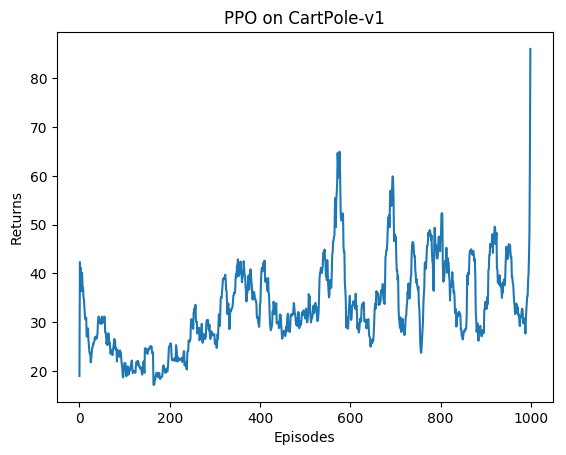

In [37]:
def moving_average(a, window_size):
    cumulative_sum = np.cumsum(np.insert(a, 0, 0)) 
    middle = (cumulative_sum[window_size:] - cumulative_sum[:-window_size]) / window_size
    r = np.arange(1, window_size-1, 2)
    begin = np.cumsum(a[:window_size-1])[::2] / r
    end = (np.cumsum(a[:-window_size:-1])[::2] / r)[::-1]
    return np.concatenate((begin, middle, end))

episodes_list = list(range(len(return_list)))
mv_return = moving_average(return_list, 19)
model_name = agent.__class__.__name__ 
plt.plot(episodes_list, mv_return)
plt.xlabel('Episodes')
plt.ylabel('Returns')
plt.title(f'{model_name} on {env_name}')
plt.show()